In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.train_bn import parameter_learning
from sklearn.model_selection import train_test_split
from gmr import GMM
from scipy import stats
from sklearn.datasets import make_spd_matrix
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, parall_accuracy
import cpuinfo

## Генерация синтетических данных для проверки сетей со смесями

In [3]:
bn = dict()
bn['V'] = ['D1', 'D2', 'N1', 'N2', 'N3']
bn['E'] = [['D1', 'N1'],  ['D2', 'N1'], ['D2', 'N2'], ['N1', 'N3'], ['N1', 'N2']]

In [4]:
node_types = {'D1':'disc', 'D2': 'disc', 'N1': 'cont', 'N2': 'cont', 'N3': 'cont'}

In [5]:
n1 = 2
x1 = np.arange(n1)
p1 = tuple(np.random.dirichlet(np.ones(n1),size=1)[0])
custm1 = stats.rv_discrete(name='custm1', values=(x1, p1))

In [6]:
n2 = 4
x2 = np.arange(n2)
p2 = tuple(np.random.dirichlet(np.ones(n2),size=1)[0])
custm2 = stats.rv_discrete(name='custm2', values=(x2, p2))

In [7]:
mean = dict()
cov = dict()
for i in x1:
    for j in x2:
        n = random.randint(2,4)
        means = []
        covs = []
        for _ in range(n):
            means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
            covs.append(make_spd_matrix(3))
        mean[str(i)+str(j)] = means
        cov[str(i)+str(j)] = covs


In [8]:
df = pd.DataFrame(columns=['D1', 'D2', 'N1', 'N2', 'N3'])
df['D1'] = custm1.rvs(size=5000)
df['D2'] = custm2.rvs(size=5000)

In [9]:
df_new = pd.DataFrame()
for i in x1:
    for j in x2:
        sample = df.loc[(df['D1'] == i) & (df['D2'] == j)]
        size = sample.shape[0]
        means = mean[str(i)+str(j)]
        covs = cov[str(i)+str(j)]
        n = len(means)
        model = GMM(n_components=n, priors=[1/n for _ in range(n)], means=means, covariances=covs)
        cont_data = model.sample(size)
        sample[['N1', 'N2', 'N3']] = cont_data
        df_new = pd.concat([df_new, sample])
df_new.reset_index(inplace=True, drop=True)

<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [10]:
df_new

,D1,D2,N1,N2,N3
0,0,1,14.359222,557.038768,-80.759316
1,0,1,15.488483,555.984642,-81.432751
2,0,1,14.986376,558.050609,-79.686448
3,0,1,13.818422,557.289212,-79.655574
4,0,1,13.585891,559.245474,-77.995491
...,...,...,...,...,...
4995,1,3,386.671713,-552.331815,558.468266
4996,1,3,385.669878,-552.599284,557.940901
4997,1,3,386.221799,-554.534935,558.334295
4998,1,3,385.556715,-551.196778,557.258663


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='N1', ylabel='Density'>

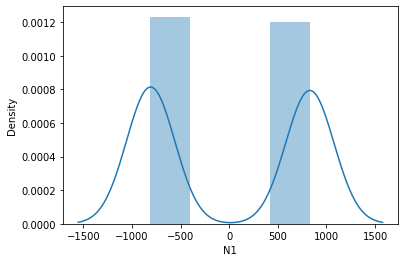

In [11]:
sample = df_new.loc[(df_new['D1'] == 0) & (df_new['D2'] == 2)]
#sns.kdeplot(df_new['N1'], df_new['N3'])
sns.distplot(sample['N1'])

In [12]:
df_new['D1'] = df_new['D1'].apply(lambda x: str(x))
df_new['D2'] = df_new['D2'].apply(lambda x: str(x))
train, test = train_test_split(df_new, test_size=0.1)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [13]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train['D1'] = train['D1'].apply(lambda x: str(x))
train['D2'] = train['D2'].apply(lambda x: str(x))
test['D1'] = test['D1'].apply(lambda x: str(x))
test['D2'] = test['D2'].apply(lambda x: str(x))

In [7]:
params = parameter_learning(train, node_types, bn, 'mix')
save_structure(bn, 'synth_net')
skel = read_structure('synth_net')
save_params(params, 'synth_net_param')
params = read_params('synth_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [8]:
cpu_count = max(cpuinfo.get_cpu_info()['count']-1, 1)
acc, rmse, real, pred, indexes = parall_accuracy(all_bn, test, bn['V'], 'mix', cpu_count)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='N1', ylabel='N3'>

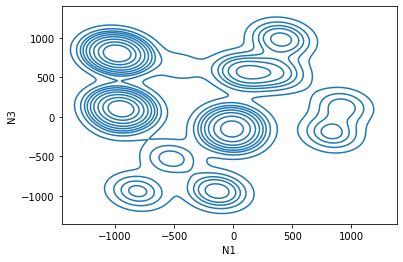

In [15]:
# sample = train.loc[(train['D1'] == '0') & (train['D2'] == '1')]
# sns.distplot(sample['N1'])
sns.kdeplot(train['N1'], train['N3'])

In [13]:
#simple
rmse

{'N1': 276.22, 'N2': 311.148, 'N3': 488.471}

In [9]:
#mix_lrts
rmse

{'N1': 274.024, 'N2': 49.506, 'N3': 381.38}

In [19]:
#mix_aic_bic
rmse

{'N1': 274.276, 'N2': 49.506, 'N3': 217.64}

In [9]:
#mix_quantile
rmse

{'N1': 275.98, 'N2': 7.852, 'N3': 189.863}